# Check heating rates for spikes at lower levels in low resolution simulations

Import python backbone libraries:

In [9]:
import numpy as np
import xarray as xr
from pathlib import Path
import shutil
import zarr
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:38894 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 24 Memory: 134.22 GB


In [3]:
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [4]:
import sys
sys.path.append('/pf/b/b380459/nawdex-hackathon/')
import dict_nawdexsims

simdict   = dict_nawdexsims.simdictionary()
colordict = dict_nawdexsims.colordictionary()

In [57]:
def load_grid_cellarea(gridres):
    path  = '/scratch/b/b380459/icon_4_hackathon/'
    dict_gridres={'80km': 'R80000m', '40km': 'R40000m', '20km': 'R20000m',
                  '10km': 'R10000m', '5km': 'R5000m', '2km': 'R2500m'}
    fname = path+'/grids/icon-grid_nawdex_78w40e23n80n_'+dict_gridres[gridres]+'.nc'
    ds = xr.open_dataset(fname)[['cell_area','clat', 'clon']].rename({'cell': 'ncells'}) 
    return ds      
                                
def load_openoceanmask(expid):
    path  = '/scratch/b/b380459/icon_4_hackathon/'
    fname = path+'/openocean_masks/'+expid+'_openoceanmask.nc'
    return xr.open_dataset(fname)['mask_openocean']
                                  
def load_data(sim):
    # open ocean mask
    da_oom = load_openoceanmask(sim)
    index  = np.where(da_oom==1)[0]
    # load data and only keep cells over open ocean
    ds_grid_cellarea = load_cellarea((simdict[sim])['res'])#.isel(ncells=index)
    zarr_store  = '/scratch/b/b380459/icon_4_hackathon/'+sim+'/'+sim+'_ddttemp_rad-from-fluxes_DOM01_ML.zarr'
    ds_fromflux = xr.open_zarr(zarr_store)#.isel(ncells=index)
    ds_dtdirect = ( xr.open_mfdataset('/scratch/b/b380459/icon_4_hackathon/'
                                       +sim+'/'+sim+'_2016*_ddttemp_DOM01_ML_00*.nc')
                    [['ddt_temp_radsw', 'ddt_temp_radlw']] )
    ds = xr.merge([ds_fromflux, ds_dtdirect, ds_grid_cellarea])
    ds['clat'] = ds['clat']*180.0/np.pi
    ds['clon'] = ds['clon']*180.0/np.pi
    return ds

In [73]:
#for sim in list(simdict.keys()):
for sim in ['nawdexnwp-80km-mis-0001']:
    print('Working on', sim)
    ds = load_data(sim)    

Working on nawdexnwp-80km-mis-0001


In [86]:
ds.compute()

<xarray.Dataset>
Dimensions:                     (height: 75, ncells: 7920, time: 98)
Coordinates:
  * height                      (height) float64 1.0 2.0 3.0 ... 73.0 74.0 75.0
  * time                        (time) datetime64[ns] 2016-09-22 ... 2016-09-...
    clon                        (ncells) float64 -78.0 -78.13 ... 33.06 33.09
    clat                        (ncells) float64 30.55 29.94 ... 35.82 31.44
Dimensions without coordinates: ncells
Data variables:
    ddt_temp_radlw_fromflux     (time, height, ncells) float32 -0.0 ... 0.000...
    ddt_temp_radlwclr_fromflux  (time, height, ncells) float32 -0.0 ... 0.000...
    ddt_temp_radsw_fromflux     (time, height, ncells) float32 -0.0 ... -0.0
    ddt_temp_radswclr_fromflux  (time, height, ncells) float32 -0.0 ... -0.0
    ddt_temp_radsw              (time, height, ncells) float32 0.0 0.0 ... 0.0
    ddt_temp_radlw              (time, height, ncells) float32 0.0 ... 0.0001...
    cell_area                   (ncells) float64 6.252e+09 ... 6.245e+09

Plot domain time means

In [23]:
ds['ddt_temp_radlw'].isel({'time':10, 'height':65}).isnull().sum().compute()

<xarray.DataArray 'ddt_temp_radlw' ()>
array(7920)
Coordinates:
    time     datetime64[ns] 2016-09-22T10:00:00
    height   float64 66.0

In [39]:
from ipywidgets import interactive

In [ ]:
def plot_heatingrates(hrds,time,height):
    var=ds[field].isel(time=time)
    plt.figure(figsize=(6,4))
    plt.tricontourf(np.rad2deg(ds.clon), np.rad2deg(ds.clat), var)
    plt.colorbar()
    plt.show()
    return

w = interactive(plot_field, field=ds.data_vars.keys(), time=(0,len(ds.time)-1,1))

output = w.children[-1]
output.layout.height = '500px'
display(w)

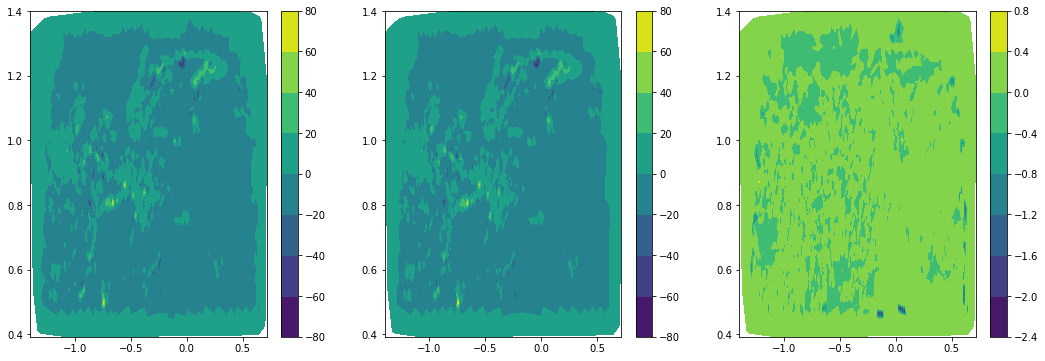

In [38]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.tricontourf(ds.clon, ds.clat,86400*ds['ddt_temp_radlw_fromflux'].isel({'time':90, 'height':65})); plt.colorbar()
plt.subplot(1,3,2)
plt.tricontourf(ds.clon, ds.clat,86400*ds['ddt_temp_radlw'].isel({'time':90, 'height':65})); plt.colorbar()
plt.subplot(1,3,3)
plt.tricontourf(ds.clon, ds.clat,86400*(ds['ddt_temp_radlw_fromflux']-ds['ddt_temp_radlw']).isel({'time':90, 'height':65})); plt.colorbar()

In [53]:
ds

<xarray.Dataset>
Dimensions:                     (height: 75, ncells: 7920, time: 98)
Coordinates:
  * height                      (height) float64 1.0 2.0 3.0 ... 73.0 74.0 75.0
  * time                        (time) datetime64[ns] 2016-09-22 ... 2016-09-...
    clon                        (ncells) float64 ...
    clat                        (ncells) float64 ...
Dimensions without coordinates: ncells
Data variables:
    ddt_temp_radlw_fromflux     (time, height, ncells) float32 dask.array<chunksize=(2, 75, 7920), meta=np.ndarray>
    ddt_temp_radlwclr_fromflux  (time, height, ncells) float32 dask.array<chunksize=(2, 75, 7920), meta=np.ndarray>
    ddt_temp_radsw_fromflux     (time, height, ncells) float32 dask.array<chunksize=(2, 75, 7920), meta=np.ndarray>
    ddt_temp_radswclr_fromflux  (time, height, ncells) float32 dask.array<chunksize=(2, 75, 7920), meta=np.ndarray>
    ddt_temp_radsw              (time, height, ncells) float32 dask.array<chunksize=(2, 75, 7920), meta=np.ndarray>
    ddt_temp_radlw              (time, height, ncells) float32 dask.array<chunksize=(2, 75, 7920), meta=np.ndarray>
    cell_area                   (ncells) float64 ...

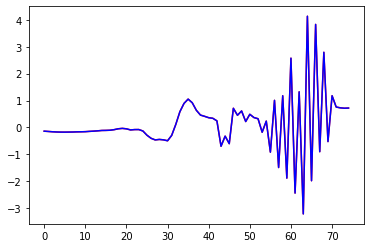

In [96]:
plt.plot(86400*(ds['ddt_temp_radlw_fromflux']-ds['ddt_temp_radlwclr_fromflux']).isel(ncells=5000).mean(['time']), 'r')
plt.plot(86400*(ds['ddt_temp_radlw']-ds['ddt_temp_radlwclr_fromflux']).isel(ncells=5000).mean(['time']), 'b')
#plt.xlim(50,75); #plt.ylim(-4,0)

In [68]:
ds = ds.where(ds.clat>35,0).where(ds.clat<60,0).where(ds.clon>-50,0).where(ds.clon<-10,0)

In [62]:
ds['clon']

<xarray.DataArray 'clon' (ncells: 7920)>
array([-78.0046618 , -78.13278646, -78.50206887, ...,  32.6801097 ,
        33.06258719,  33.08557302])
Coordinates:
    clon     (ncells) float64 -78.0 -78.13 -78.5 -77.62 ... 32.68 33.06 33.09
    clat     (ncells) float64 30.55 29.94 30.95 31.76 ... 34.23 35.82 31.44
Dimensions without coordinates: ncells

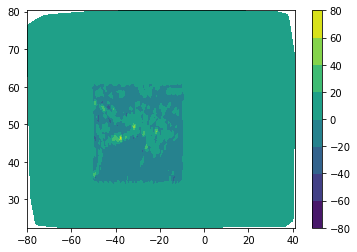

In [70]:
plt.tricontourf(ds.clon, ds.clat,86400*ds['ddt_temp_radlw_fromflux'].isel({'time':90, 'height':65})); plt.colorbar()

(50.0, 75.0)

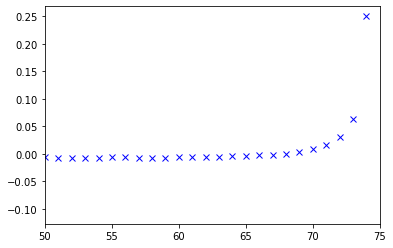

In [36]:
plt.plot(86400*ds['ddt_temp_radlw_fromflux'].isel(time=90).mean('ncells')-
         86400*ds['ddt_temp_radlw'].isel(time=90).mean('ncells'), 'bx')
plt.xlim(50,75)

In [27]:
(ds['ddt_temp_radlw_fromflux'].isel(time=90).mean('ncells') - ds['ddt_temp_radlw'].isel(time=90).mean('ncells')).compute()

<xarray.DataArray (height: 75)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-09-25T18:00:00
  * height   (height) float64 1.0 2.0 3.0 4.0 5.0 ... 71.0 72.0 73.0 74.0 75.0